# Lambda Iterations

In [1]:
import os
import sys

magritteFolder = '/home/frederik/Dropbox/GitHub/Magritte/'

sys.path.append(magritteFolder)

import numpy             as np
import matplotlib.pyplot as plt
import magritte.setup    as setup
import magritte.core     as magritte

In [2]:
dimension = 1
npoints   = 100
nrays     = 200
nspecs    = 5
nlspecs   = 1
nquads    = 15

r_in   = 1.0E13   # [m]
r_out  = 7.8E16   # [m]
nH2_in = 2.0E13   # [m^-3]
X_mol  = 1.0E-6   # [.]
temp   = 20.0     # [K]
turb   = 150.00   # [.]


def nH2 (r):
    return nH2_in * np.power(r_in/r, 2.0)

def nTT (r):
    return X_mol  * nH2(r)


rs = np.logspace (np.log10(r_in), np.log10(r_out), npoints, endpoint=True)


modelFile = 'vanZadelhoff_1a_1D.hdf5'
lamdaFile = f'{magritteFolder}tests/data/test.txt'


model = magritte.Model ()
model.parameters.set_spherical_symmetry(True)
model.parameters.set_pop_prec          (1.0e-6)
model.parameters.set_model_name        (modelFile)
model.parameters.set_dimension         (dimension)
model.parameters.set_npoints           (npoints)
model.parameters.set_nrays             (nrays)
model.parameters.set_nspecs            (nspecs)
model.parameters.set_nlspecs           (nlspecs)
model.parameters.set_nquads            (nquads)

model.geometry.points.position.set([[r, 0, 0] for r in rs])
model.geometry.points.velocity.set(np.zeros((npoints, 3)))

model.chemistry.species.abundance = [[     0.0, nTT(r), nH2(r),  0.0,      1.0] for r in rs]
model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

model = setup.set_Delaunay_neighbor_lists (model)
model = setup.set_Delaunay_boundary       (model)
model = setup.set_boundary_condition_CMB  (model)
model = setup.set_rays_spherical_symmetry (model)
model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
model = setup.set_quadrature              (model)

model.write()
model.read ()

model.compute_spectral_discretisation ()
model.compute_inverse_line_widths     ()
model.compute_LTE_level_populations   ()

0

In [3]:
def max_relative_difference(a, b):
    return np.max(2.0 * np.abs((a - b) / (a + b)))

In [4]:
Nmax = 250

max_diffs = []

pops = []
pop  = np.copy(model.lines.lineProducingSpecies[0].population)
pops.append(pop)

for it in range(Nmax):
    # Compute radiation field and resulting populations
    model.compute_radiation_field_feautrier_order_2()
    model.compute_Jeff()
    model.compute_level_populations_from_stateq()
    # Compute the maximum relative change
    pop = np.copy(model.lines.lineProducingSpecies[0].population)
    pops.append(pop)
    max_diff = max_relative_difference(pops[-1], pops[-2])
    max_diffs.append(max_diff)
    # Check for convergence
    if (max_diff < 1.0e-6):
        break
    print('After', it, 'iteration(s), max_diff =', max_diff)

After 0 iteration(s), max_diff = 0.67532867319667438163
After 1 iteration(s), max_diff = 0.41134736876887022407
After 2 iteration(s), max_diff = 0.25672685590981898275
After 3 iteration(s), max_diff = 0.1902453155089560047
After 4 iteration(s), max_diff = 0.1523181743951932173
After 5 iteration(s), max_diff = 0.12759521660850900572
After 6 iteration(s), max_diff = 0.110074748116086370804
After 7 iteration(s), max_diff = 0.09733701897109957774
After 8 iteration(s), max_diff = 0.08731154741671383308
After 9 iteration(s), max_diff = 0.079329335412878955825
After 10 iteration(s), max_diff = 0.07292661318096562752
After 11 iteration(s), max_diff = 0.06758406046136118653
After 12 iteration(s), max_diff = 0.06306637782956355452
After 13 iteration(s), max_diff = 0.05919545288459485238
After 14 iteration(s), max_diff = 0.055835172958732542827
After 15 iteration(s), max_diff = 0.05294965639144907682
After 16 iteration(s), max_diff = 0.05042596695045739735
After 17 iteration(s), max_diff = 0.0481

In [24]:
def VZp1_pops(nod):

    dimension = 1
    npoints   = 100
    nrays     = 200
    nspecs    = 5
    nlspecs   = 1
    nquads    = 15

    r_in   = 1.0E13   # [m]
    r_out  = 7.8E16   # [m]
    nH2_in = 2.0E13   # [m^-3]
    X_mol  = 1.0E-6   # [.]
    temp   = 20.0     # [K]
    turb   = 150.00   # [.]


    def nH2 (r):
        return nH2_in * np.power(r_in/r, 2.0)

    def nTT (r):
        return X_mol  * nH2(r)


    rs = np.logspace (np.log10(r_in), np.log10(r_out), npoints, endpoint=True)


    modelFile = 'vanZadelhoff_1a_1D.hdf5'
    lamdaFile = f'{magritteFolder}tests/data/test.txt'


    model = magritte.Model ()
    model.parameters.set_spherical_symmetry(True)
    model.parameters.set_pop_prec          (1.0e-6)
    model.parameters.set_model_name        (modelFile)
    model.parameters.set_dimension         (dimension)
    model.parameters.set_npoints           (npoints)
    model.parameters.set_nrays             (nrays)
    model.parameters.set_nspecs            (nspecs)
    model.parameters.set_nlspecs           (nlspecs)
    model.parameters.set_nquads            (nquads)
    model.parameters.n_off_diag            = nod

    model.geometry.points.position.set([[r, 0, 0] for r in rs])
    model.geometry.points.velocity.set(np.zeros((npoints, 3)))

    model.chemistry.species.abundance = [[     0.0, nTT(r), nH2(r),  0.0,      1.0] for r in rs]
    model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

    model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
    model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

    model = setup.set_Delaunay_neighbor_lists (model)
    model = setup.set_Delaunay_boundary       (model)
    model = setup.set_boundary_condition_CMB  (model)
    model = setup.set_rays_spherical_symmetry (model)
    model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
    model = setup.set_quadrature              (model)

    model.write()
    model.read ()

    model.compute_spectral_discretisation ()
    model.compute_inverse_line_widths     ()
    model.compute_LTE_level_populations   ()

    Nmax = 250

    max_diffs = []

    pops = []
    pop    = np.copy(model.lines.lineProducingSpecies[0].population)
    pops.append(pop)

    for it in range(Nmax):
        # Compute radiation field and resulting populations
        model.compute_radiation_field_feautrier_order_2()
        model.compute_Jeff()
        model.compute_level_populations_from_stateq()
        # Compute the maximum relative change
        pop = np.copy(model.lines.lineProducingSpecies[0].population)
        
        pops.append(pop)
        max_diff = max_relative_difference(pops[-1], pops[-2])
        max_diffs.append(max_diff)
        # Check for convergence
        if (max_diff < 1.0e-6):
            break
        print('After', it, 'iteration(s), max_diff =', max_diff)
        
    return pops, max_diffs

In [42]:
pop[pop<1.0e+2] = 1.0e+2
nrm = np.sum(pop.reshape(npoints, -1), axis=1) / np.array(model.chemistry.species.abundance)[:,1]
pop = pop.reshape(npoints, -1) / nrm[:, np.newaxis]

In [43]:
np.sum(pop.reshape(npoints, -1), axis=1) / np.array(model.chemistry.species.abundance)[:,1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float128)

In [44]:
nrm

array([  1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.03293489,   1.10270096,   1.18069365,   1.26

In [29]:
np.sum(pop, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [25]:
pops_0, max_diffs_0 = VZp1_pops(nod=0)
pops_2, max_diffs_2 = VZp1_pops(nod=2)
pops_4, max_diffs_4 = VZp1_pops(nod=4)

After 0 iteration(s), max_diff = 0.67532867319667438163
After 1 iteration(s), max_diff = 0.41134736876887022407
After 2 iteration(s), max_diff = 0.25672685590981898275
After 3 iteration(s), max_diff = 0.1902453155089560047
After 4 iteration(s), max_diff = 0.1523181743951932173
After 5 iteration(s), max_diff = 0.12759521660850900572
After 6 iteration(s), max_diff = 0.110074748116086370804
After 7 iteration(s), max_diff = 0.09733701897109957774
After 8 iteration(s), max_diff = 0.08731154741671383308
After 9 iteration(s), max_diff = 0.079329335412878955825
After 10 iteration(s), max_diff = 0.07292661318096562752
After 11 iteration(s), max_diff = 0.06758406046136118653
After 12 iteration(s), max_diff = 0.06306637782956355452
After 13 iteration(s), max_diff = 0.05919545288459485238
After 14 iteration(s), max_diff = 0.055835172958732542827
After 15 iteration(s), max_diff = 0.05294965639144907682
After 16 iteration(s), max_diff = 0.05042596695045739735
After 17 iteration(s), max_diff = 0.0481

In [7]:
from matplotlib import pyplot   as plt
from matplotlib import gridspec, rcParams, rc, cm, colors

rcParams.update({'font.size': 13})
rc('text', usetex=True)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

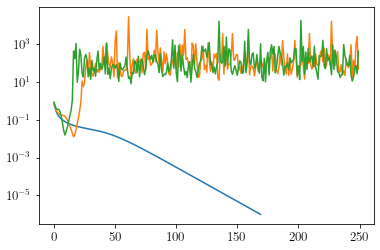

In [26]:
plt.plot(max_diffs_0)
plt.plot(max_diffs_2)
plt.plot(max_diffs_4)
plt.yscale('log')

In [19]:
len(pops)%4

3

In [ ]:
def Ng_acceleration(pops, order):
    
    if len(pops)%order != 0
    

In [12]:
Ys = np.array(pops, dtype=float)
Ys = Ys[5:,:]
Es1 = []
Es2 = []

for i in range(2, Ys.shape[0]+1):
#     print(i)
    ys = Ys[:i,:]
    rs = ys[1:,:] - ys[:-1,:]
    cs1 = np.linalg.solve(np.matmul(rs, rs.T), np.ones(rs.shape[0]))
    cs1 = cs1 / np.sum(cs1)
    cs2 = np.linalg.solve(np.matmul(rs, rs.T) + 1.0e-6*np.eye(rs.shape[0]), np.ones(rs.shape[0]))
    cs2 = cs2 / np.sum(cs2)
    nw1 = np.matmul(cs1, ys[:-1,:])
    nw2 = np.matmul(cs2, ys[:-1,:])
    Es1.append(nw1)
    Es2.append(nw2)
    
Es1 = np.array(Es1)
Es2 = np.array(Es2)
Ds1 = np.max(Es1[1:,:] - Es1[:-1,:], axis=1)
Ds2 = np.max(Es2[1:,:] - Es2[:-1,:], axis=1)

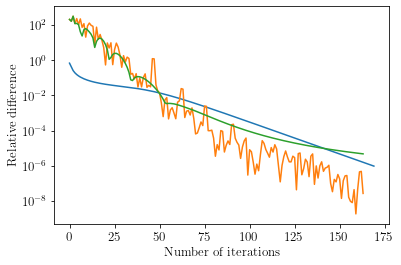

In [17]:
plt.plot(max_diffs)
plt.plot(Ds1)
plt.plot(Ds2)
plt.xlabel('Number of iterations')
plt.ylabel('Relative difference')
plt.yscale('log')

In [43]:
Ds

(164,)

In [11]:
ys = np.array(pops, dtype=float)

In [12]:
ys.shape

(166, 200)

In [14]:
R = ys[1:,:] - ys[:-1,:]

In [15]:
R.shape

(165, 200)

In [22]:
cs = np.linalg.solve(np.matmul(R, R.T), np.ones(R.shape[0]))
cs = cs / np.sum(cs)

In [20]:
np.linalg.cond(np.matmul(R, R.T))

9.040704754521604e+25

In [26]:
new1 = np.matmul(cs, ys[1:,:])
new2 = np.matmul(cs, ys[:-1,:])

array([ 1.86264515e-09, -1.86264515e-09, -9.31322575e-10,  0.00000000e+00,
       -9.31322575e-10,  1.86264515e-09, -9.31322575e-10,  0.00000000e+00,
        0.00000000e+00, -1.86264515e-09,  0.00000000e+00,  9.31322575e-10,
       -9.31322575e-10,  9.31322575e-10,  2.32830644e-10,  1.39698386e-09,
        2.32830644e-10, -4.65661287e-10,  2.32830644e-10,  0.00000000e+00,
        2.32830644e-10,  0.00000000e+00, -1.16415322e-10,  0.00000000e+00,
       -2.32830644e-10,  6.98491931e-10, -1.16415322e-10,  2.32830644e-10,
        1.16415322e-10,  0.00000000e+00, -1.16415322e-10,  1.16415322e-10,
        5.82076609e-11,  0.00000000e+00, -5.82076609e-11,  0.00000000e+00,
       -5.82076609e-11, -1.16415322e-10,  2.91038305e-11,  1.74622983e-10,
       -2.91038305e-11,  0.00000000e+00,  2.91038305e-11, -5.82076609e-11,
       -4.36557457e-11,  0.00000000e+00, -4.36557457e-11, -5.82076609e-11,
        0.00000000e+00,  5.82076609e-11,  0.00000000e+00,  0.00000000e+00,
       -1.45519152e-11,  